In [1]:
!pip install lmfit
!pip install requests

In [2]:

from matplotlib import pyplot as plt
import numpy as np
from scipy.integrate import odeint
import scipy.optimize as optim
import sympy as sp 
import pandas as pd
from lmfit import Parameters, minimize, report_fit
import requests

In [3]:
Nma=36.89e6 #morocco
Nes=46.7e6 #Spain
Nde=83.7e6 #Germany
Nalg=43.8e6 #1lgeria
Nmx=128.86e6 #mexico
Nfr=65.26e6 #france
Nit=60.464e6#Italy
Nch=1.439196e9#Italy

In [4]:
def getParams(N,p,beta,gamma,sigma,tc,eps):
    fit_params = Parameters()
    fit_params.add('N', value=N,vary=False)
    fit_params.add('p', value=p,min=1, max=1e6)
    fit_params.add('beta', value=beta, min=0, max=10) #0.2
    fit_params.add('gamma', value=gamma, min=0, max=1.0)#0.02
    fit_params.add('sigma', value=sigma, min=0, max=1.0)#0.01
    fit_params.add('tc', value=tc,vary=False)#20
    fit_params.add('eps', value=eps, vary=False)#8
    return fit_params

In [5]:
def getCountryData(country):
  r = requests.get('https://api.covid19api.com/dayone/country/'+country)
  res=r.json()
  df=pd.DataFrame(res)
  df=df[df["Province"]==""]
  I=np.array(df['Confirmed'])
  return I

# Equation 2.1
$$
\displaystyle \frac{ d\:I_c{(t)}}{d\:t} = r I_c (t)\Big[1- \frac{I_c(t)}{K} \Big]
$$
$$
\displaystyle I_c{(t)}= \frac{ K}{ 1+ \exp(-r (t-t_0-\tau))}
$$
$$\displaystyle \tau=\frac{1}{r} \log \Big(\frac{K}{I_c (t_0)}-1\Big)$$

# Equation 2.8
$$\displaystyle I_f(t):= \frac{ d\:I_c{(t)}}{d\:t} =  \frac{r K \exp(-r (t-t_0-\tau))}{\Big[ 1+ \exp(-r (t-t_0-\tau))\Big]^{2}}
$$

In [6]:
def logistic(t,tau,r,k):
    return k/(1+np.exp(-r*(t-tau)))

def logisticf(t,tau,r,k):
  return r*k*np.exp(-r*(t-tau))/((1+np.exp(-r*(t-tau)))**2)


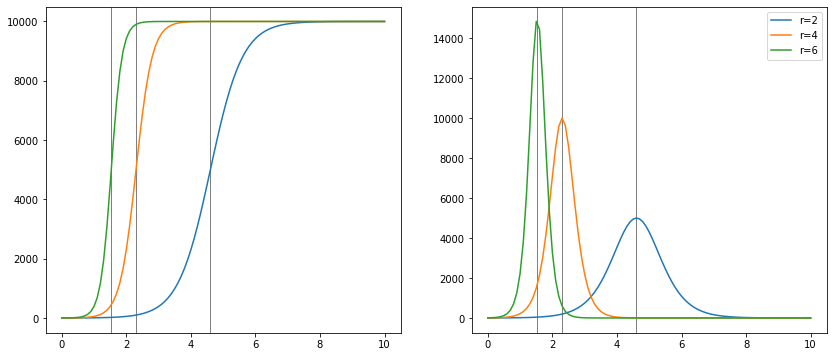

In [20]:

k=1e4
t=np.linspace(0,10,101)
fig, axs= plt.subplots(1, 2,sharex=True,figsize=[14, 6])
r=2
tau=(np.log(k-1))/r
axs[0].axvspan(tau, tau,linestyle="-", color='gray')
axs[0].plot(t,logistic(t,tau,r,k),label="r="+str(r))
axs[1].axvspan(tau, tau, linestyle="-",color='gray')
axs[1].plot(t,logisticf(t,tau,r,k),label="r="+str(r))


r=4
tau=(np.log(k-1))/r
axs[0].axvspan(tau, tau,linestyle="-", color='gray')
axs[0].plot(t,logistic(t,tau,r,k),label="r="+str(r))
axs[1].axvspan(tau, tau,linestyle="-", color='gray')
axs[1].plot(t,logisticf(t,tau,r,k),label="r="+str(r))


r=6
tau=(np.log(k-1))/r
axs[0].axvspan(tau, tau,linestyle="-",  color='gray')
axs[0].plot(t,logistic(t,tau,r,k),label="r="+str(r))
axs[1].axvspan(tau, tau, linestyle="dashed", color='gray')
axs[1].plot(t,logisticf(t,tau,r,k),label="r="+str(r))
axs[1].legend()
fig.savefig("logistic.png", dpi=150)

# Equation 2.8
$$
\displaystyle I_c{(t)}= \frac{ K}{ \Big[ 1+ \exp(- \gamma r (t-t_0-\tau)) \Big]^{1/\gamma}}
$$
$$
\displaystyle I_f(t):= \frac{ d\:I_c{(t)}}{d\:t} =  \frac{r K \exp(-r \gamma(t-t_0-\tau))}{\Big[ 1+ \exp(-r (t-t_0-\tau))\Big]^{ 1+\frac{1}{\gamma}}}.
$$

In [12]:
def logisticG(t,tau,r,k,gamma):
    return k/((1+np.exp(-gamma*r*(t-tau)))**(1/gamma))

def logisticGf(t,tau,r,k,gamma):
  return r*k*np.exp(-r*gamma*(t-tau))/((1+np.exp(-r*(t-tau)))**(1+(1/gamma)))

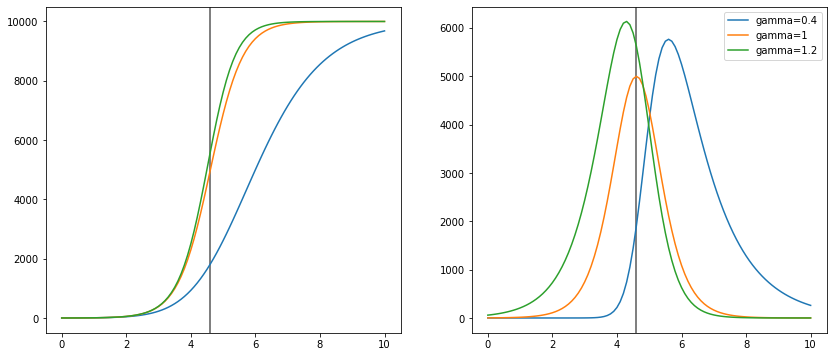

In [26]:
k=1e4
t=np.linspace(0,10,101)
fig, axs= plt.subplots(1, 2,sharex=True,figsize=[14, 6])
r=2
gamma=0.4
tau=(np.log(k**gamma-1))/(r*gamma)
axs[0].axvspan(tau, tau,linestyle="-", color='gray')
axs[0].plot(t,logisticG(t,tau,r,k,gamma),label="gamma="+str(gamma))
axs[1].axvspan(tau, tau, linestyle="-",color='gray')
axs[1].plot(t,logisticGf(t,tau,r,k,gamma),label="gamma="+str(gamma))


gamma=1
tau=(np.log(k**gamma-1))/(r*gamma)
axs[0].axvspan(tau, tau,linestyle="-", color='gray')
axs[0].plot(t,logisticG(t,tau,r,k,gamma),label="gamma="+str(gamma))
axs[1].axvspan(tau, tau, linestyle="-",color='gray')
axs[1].plot(t,logisticGf(t,tau,r,k,gamma),label="gamma="+str(gamma))


gamma=1.2
tau=(np.log(k**gamma-1))/(r*gamma)
axs[0].axvspan(tau, tau,linestyle="-", color='gray')
axs[0].plot(t,logisticG(t,tau,r,k,gamma),label="gamma="+str(gamma))
axs[1].axvspan(tau, tau, linestyle="-",color='gray')
axs[1].plot(t,logisticGf(t,tau,r,k,gamma),label="gamma="+str(gamma))
axs[1].legend()
fig.savefig("logisticG.png", dpi=150)

In [18]:
def bilogistic(t,a1,b1,c1,a2,b2,c2):
    return (c1/(1+np.exp(-b1*(t-a1))))+(c2/(1+np.exp(-b2*(t-a2))))


In [ ]:
def bilogisticgama(t,a1,b1,c1,gama1,a2,b2,c2,gama2):
    return (c1/(1+np.exp(-b1*gama1*(t-a1))**(1/gama1)))+(c2/(1+np.exp(-b2*gama2*(t-a2)))**(1/gama2))

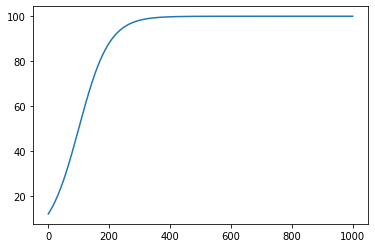

In [ ]:
plt.plot(logistic(np.linspace(0,10,1001),1,2,100))

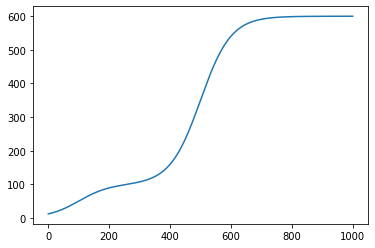

In [ ]:
plt.plot(bilogistic(np.linspace(0,10,1001),1,2,100,5,2,500))

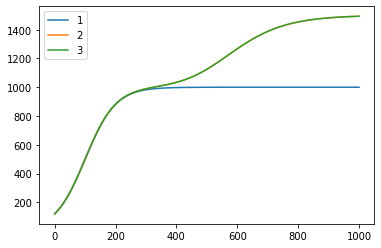

In [ ]:
plt.figure()
plt.plot(bilogisticgama(np.linspace(0,10,1001),1,2,1000,1.0/3,5,2,500,1.0/20),label="1")
plt.plot(bilogisticgama(np.linspace(0,10,1001),1,2,1000,1.0/3,5,2,500,1.0/2),label="2")
plt.plot(bilogisticgama(np.linspace(0,10,1001),1,2,1000,1.0/3,5,2,500,1.0/2),label="3")
plt.legend()

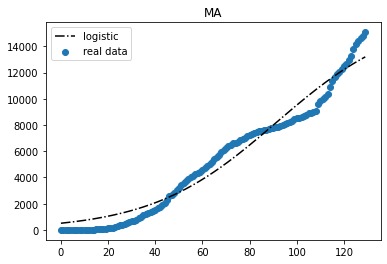

In [ ]:
def fitFor(countryCode,N,forcast):
    I=getCountryData(countryCode)
    n=I.size
    x=np.linspace(0,n-1,n)
    plt.figure()
    plt.scatter(x,I,label="real data")
    bounds=(0,[1e6,10,N])
    p0=np.random.exponential(size=3)
    (a,b,c),cov=optim.curve_fit(logistic,x,I,bounds=bounds,p0=p0)
    #x=np.linspace(0,n-1+forcast,n+forcast)
    out=logistic(x,a,b,c)
    plt.plot(x,out,label="logistic", linestyle='dashdot', color="black")
    plt.legend()
    plt.title(countryCode)
    return out
Yma=fitFor("MA",Nma,0)

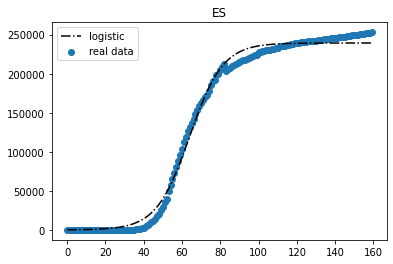

In [ ]:
Ysp=fitFor("ES",Nes,0)

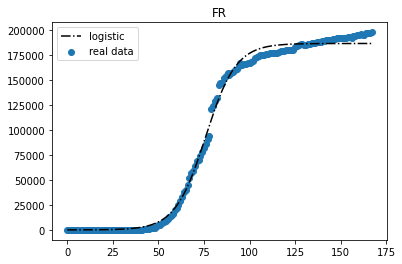

In [ ]:
Yfr=fitFor("FR",Nfr,0)

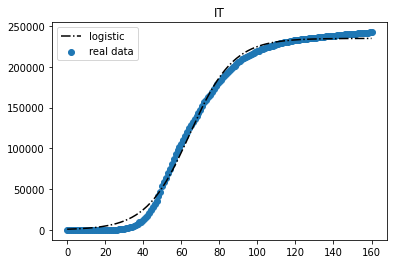

In [ ]:
Yit=fitFor("IT",Nit,0)

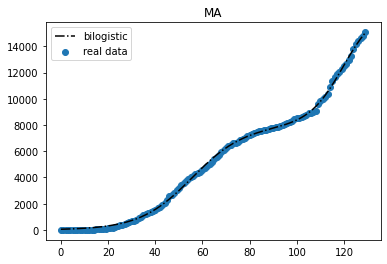

In [ ]:
def BifitFor(countryCode,N,forcast):
    I=getCountryData(countryCode)
    n=I.size
    x=np.linspace(0,n-1,n)
    plt.figure()
    #plt.plot(x,I,linestyle='dotted',color="red", label="real")
    plt.scatter(x,I,label="real data")
    bounds=(0,[1e6,10,36e6,1e6,10,36e6])
    p0=np.random.exponential(size=6)
    (a1,b1,c1,a2,b2,c2),cov=optim.curve_fit(bilogistic,x,I,bounds=bounds,p0=p0)
    #print(a,b,c)
    x=np.linspace(0,n-1+forcast,n+forcast)
    Y=bilogistic(x,a1,b1,c1,a2,b2,c2)
    plt.plot(x,Y,label="bilogistic", linestyle='dashdot', color="black")
    plt.legend()
    plt.title(countryCode)
    return Y
Yma=BifitFor("MA",Nma,0)

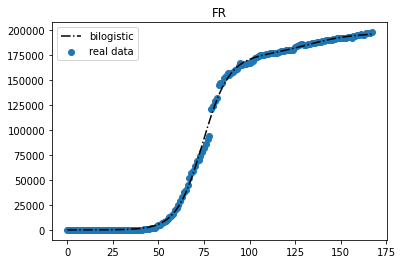

In [ ]:
Yfr=BifitFor("FR",Nfr,0)

In [ ]:
Yes=BifitFor("ES",Nes,0)

In [ ]:
Yit=BifitFor("IT",Nit,0)

In [ ]:
def BifitForgama(countryCode,N,forcast):
    I=getCountryData(countryCode)
    n=I.size
    x=np.linspace(0,n-1,n)
    plt.figure()
    #plt.plot(x,I,linestyle='dotted',color="red", label="real")
    plt.scatter(x,I,label="real data")
    bounds=(0,[1e6,10,36e6,5,1e6,10,36e6,5])
    p0=np.random.exponential(size=8)
    (a1,b1,c1,gama1,a2,b2,c2,gama2),cov=optim.curve_fit(bilogisticgama,x,I,bounds=bounds,p0=p0)
    #print(a,b,c)
    x=np.linspace(0,n-1+forcast,n+forcast)
    Y=bilogisticgama(x,a1,b1,c1,gama1,a2,b2,c2,gama2)
    plt.plot(x,Y,label="bilogisticgama", linestyle='dashdot', color="black")
    plt.legend()
    plt.title(countryCode)
    return Y
Y=BifitForgama("MA",Nma,0)
BifitForgama("FR",Nfr,0)
BifitForgama("ES",Nes,0)
BifitForgama("IT",Nit,0)


In [ ]:
fit_params = Parameters()
fit_params.add('K', value=1e4,vary=False)
fit_params.add('tc', value=40,vary=False)
fit_params.add('eps', value=15,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=0.1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

In [ ]:
def getP(Tc,Tmax,p,eps):
    P=np.ones(Tmax+1)
    for i in range(Tc,Tc+eps+1):
      P[i]=1+(p-1)*(i-Tc)/eps 
    for i in range(Tc+eps+1,Tmax+1):
      P[i]=p
    return P

def l(r,P):
    return np.power(r,P)
    

In [ ]:
def deriv(y, x, K , r,gamma, p,tc,eps):
    I = y
    pp=1
    if(tc<x<tc+eps): pp=1+(p-1)*(x-tc)/eps 
    elif(tc+eps<x): pp=p
    dIdt = r*l(I,pp)*(1-np.power(I/K,gamma))
    return dIdt

In [ ]:
def f(params,x,y0):
    K= params["K"]
    p= params["p"].value
    eps= params["eps"].value
    tc= params["tc"].value
    gamma= params["gamma"].value
    r= params["r"].value
    return (odeint(deriv, y0, x, args=(K,r,gamma,p,tc,eps)).T)[0]


In [ ]:
def objective(params,f,x,data,y0):
    # Initial number of infected and recovered individuals, I0 and R0.
    ndata=x.size
    resid = 0.0*data
    ret=f(params,x,y0)
    resid= data- ret
    return resid.flatten()

In [ ]:
fit_params = Parameters()
fit_params.add('K', value=1e4,vary=True)
fit_params.add('tc', value=40,vary=False)
fit_params.add('eps', value=15,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=0.1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

data=getCountryData("MA")
n=data.shape[0]
print(n)
x=np.linspace(1,n,n)
y0=1

out = minimize(objective, fit_params,  args=(f,x,data,y0))
report_fit(out.params)
x=np.linspace(1,n+10,n+10)
sim=f(out.params,x,1)
fitFor("MA",Nma,10)
#plt.figure()

plt.plot(sim,label="RichardsP",color="red")
#plt.plot(data,linestyle="dotted",label="real")
plt.legend()
plt.savefig("finalresult.png", dpi=150)

In [ ]:
fit_params = Parameters()
fit_params.add('K', value=10e4,vary=True)
fit_params.add('tc', value=53,vary=False)
fit_params.add('eps', value=10,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=0.1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

data=getCountryData("Fr")
n=data.shape[0]
print(n)
x=np.linspace(1,n,n)
y0=1

out = minimize(objective, fit_params,  args=(f,x,data,y0))
report_fit(out.params)
x=np.linspace(1,n+100,n+100)
sim=f(out.params,x,1)
fitFor("fr",100)
#plt.figure()

plt.plot(sim,label="RichardsP",color="red")
#plt.plot(data,linestyle="dotted",label="real")
plt.legend()
plt.savefig("finalresult.png", dpi=150)

In [ ]:
fit_params = Parameters()
fit_params.add('K', value=10e6,vary=True)
fit_params.add('tc', value=50,vary=False)
fit_params.add('eps', value=10,vary=False)
fit_params.add('gamma', value=1, min=0)
fit_params.add('p', value=1, min=0,max=0.99)
fit_params.add('r', value=1, min=0)

data=getCountryData("DE")
n=data.shape[0]
print(n)
x=np.linspace(1,n,n)
y0=1

out = minimize(objective, fit_params,  args=(f,x,data,y0))
report_fit(out.params)
x=np.linspace(1,n+100,n+100)
sim=f(out.params,x,1)
fitFor("DE",100)
#plt.figure()

plt.plot(sim,label="RichardsP",color="red")
#plt.plot(data,linestyle="dotted",label="real")
plt.legend()
plt.savefig("finalresult.png", dpi=150)

# Equation2.5

# 1. K(t)

$$ \frac{ d\:K(t)}{d\:t} = a  (K(t)-K_\beta) \Big(1- \frac{K(t)-K_\beta}{K_\alpha}\Big) $$
$$  \displaystyle K{(t)}= K_\beta+\frac{ K_\alpha (K(t_0)-K_\beta)}{ (K(t_0)-K_\beta)+ (K_\alpha+K_\beta- K(t_0))\exp(-a (t-t_0))}$$

In [ ]:
def K(t,K0,alpha,Kbeta, Kalpha):
    return Kbeta+((Kalpha*(K0-Kbeta))/((K0-Kbeta)+( (Kalpha+Kbeta-K0)*(np.exp(-alpha*t)))))
x=np.linspace(0,1000,1001)
plt.plot(x,K(x,30.001,0.015,30,105))
#plt.plot(x,K(x,10,-0.001,100))
#plt.plot(x,K(x,1,-0.001,5))

In [ ]:
def KK(y, x, Kbeta,Kalpha , a,gamma2):
    K = y
    dIdt = Kbeta+a*(K-Kbeta)*(1-np.power((K-Kbeta)/Kalpha,gamma2))
    return dIdt

# 2. P(t)
\begin{equation}\label{p}
p_\delta(t)=
\begin{cases}
\displaystyle 1  &\qquad \mbox{if}  \qquad  t\leq t_c\\ 
\displaystyle  \frac{p^\star-1}{\delta} (t-t_c) + 1 & \qquad \mbox{if}  \qquad t_c \leq t\leq t_c+\delta\\ 
\displaystyle  p^\star  &\qquad \mbox{if}  \qquad   t_c+\delta \leq t \leq  t_d-\delta \\
\displaystyle  \frac{1-p^\star}{\delta} (t-t_d) + 1 & \qquad \mbox{if}  \qquad t_d-\delta \leq t\leq t_d\\ 
\displaystyle 1  &\qquad \mbox{if}  \qquad  t\geq t_d \\ 
\end{cases}
\end{equation}

In [ ]:
def Pdelta(p,Tc,Td,Tmax,delta):
    P=np.ones(Tmax)
    for i in range(Tc,Tc+delta):
      P[i]=1+(p-1)*(i-Tc)/delta 
    for i in range(Tc+delta,Td-delta):
      P[i]=p
    for i in range(Td-delta,Td):
      P[i]=1+(1-p)*(i-Td)/delta 
    return P

def l(r,P):
    return np.power(r,P)

# Equation 2.5
\begin{equation}\label{LogisticP}
\begin{cases}
\displaystyle \frac{ d\:I_{c}(t)}{d\:t} = -r  I^{p_\delta(t)}_c(t) \Big(1- \big(\frac{I_{c}(t)}{K(t)}\big)^{\gamma} \Big) \\ \\
\displaystyle \frac{ d\:K(t)}{d\:t} = \alpha  (K(t)-K_\beta) \Big(1- \frac{K(t)-K_\beta}{K_\alpha}\Big) 
\end{cases}
\end{equation}
In  general, after the start of the evolution of the epidemic, there is a  large reduction of infected by a social distancing measures.  For that, we assume that
 $ p(t)=1 $  for $ t \notin [t_d, t_c]$ and $ p(t) ={p^\star}$  with $0\leq {p^\star}<1$ , where $t_c$ and $t_d$ are  the time of beginning and stopping  confinement respectively . A typical examples is 
 where $p_\delta(t)$ a continuous function  such that


In [ ]:
def getParams(K0,alpha,Kbeta,Kalpha,r,gamma,p):
    fit_params = Parameters()
    fit_params.add('K0', value=K0,vary=True)
    fit_params.add('p', value=p,min=0, max=1)
    fit_params.add('gamma', value=gamma)
    fit_params.add('Kalpha', value=Kalpha)
    fit_params.add('Kbeta', value=Kbeta)
    fit_params.add('alpha', value=alpha)
    fit_params.add('r', value=r)
    return fit_params

In [ ]:
def deriv2(y, x, K0,alpha, Kbeta,Kalpha , r,gamma, p):
    I= y
    Kt=K(x,K0,alpha,Kbeta, Kalpha)
    #print(K)
    dIdt=r*(I**p)*(1-(I/Kt)**gamma)
    return dIdt

In [ ]:
def f2(params,x,y0):
    K0= params["K0"]
    p= params["p"].value
    r= params["r"].value
    gamma= params["gamma"].value
    Kalpha= params["Kalpha"].value
    Kbeta= params["Kbeta"].value
    alpha= params["alpha"].value
    return odeint(deriv2, y0, x, args=(K0,alpha,Kbeta,Kalpha, r, gamma, p))

In [ ]:
d=getCountryData("MA")
plt.plot(d)
n=d.size
params=getParams(5000,0.3,200,15000,0.1,1,1) #(K0,alpha,Kbeta,Kalpha,r,gamma,p)
print(n)
x=np.linspace(0,n,n)
y=f2(params,x,1)
z=K(x,5000,0.3,200,15000)#(t, K0,alpha,Kbeta,Kalpha)
#print(z)
plt.plot(y,label="I(t)")
plt.plot(z,label='k(t)')
plt.legend()
y0=1

out = minimize(objective, params, nan_policy='omit', args=(f2,x,d[:n],y0))
report_fit(out.params)
x=np.linspace(1,n,n)
y=f(out.params,x,y0)


# Equation 3.2

\begin{equation}
 \begin{cases}
\displaystyle \frac{ d v_c}{d t} & \displaystyle= r^2 p I^{2p-1}_c \Big[1-(1+\frac{\gamma}{p}) \Big(\frac{I_c}{K}\Big)^\gamma \Big]  \Big(1- \Big(\frac{I_{c}}{K}\big)^{\gamma} \Big) \\ \\
\displaystyle \frac{ d I_c}{d t}&=v_c
\end{cases}
\end{equation}


In [ ]:
#@title Titre par défaut
y0=[1,0]
def wave(y, x, r,gamma,p,k):
  I, v = y
  A=np.power(r,2)*p*np.power(I,2*p-1)
  B=1.-(1.+(gamma/p))*np.power(I/k,gamma)
  C=1.-np.power(I/k,gamma)
  dIdt=A*B*C
  dvdt=0.5*I
  return dIdt,dvdt
#def GG(y, t):
#    return np.diag([0, 0, 0, 100])

n=1000
x= np.linspace(0, n, 10*n)

sol = odeint(wave, y0, x, args=(0.5,1,0.9,1e4)).T
plt.plot(x,sol[0])



In [ ]:
mu = 1.0

def vanderpol(X, t):
    x = X[0]
    y = X[1]
    dxdt = mu * (x - 1./3.*x**3 - y)
    dydt = x / mu
    return [dxdt, dydt]

X0 = [1, 2]
t = np.linspace(0, 40, 250)

sol = odeint(vanderpol, X0, t)
x = sol[:, 0]
y = sol[:, 1]

plt.plot(t,x, t, y)
plt.xlabel('t')
plt.legend(('x', 'y'))


# phase portrait
plt.figure()
plt.plot(x,y)
plt.plot(x[0], y[0], 'ro')
plt.xlabel('x')
plt.ylabel('y')

In [ ]:
#@title Titre par défaut
y0=[1,0]
def wave(y, x, r,gamma,p,k):
  I, v = y
  A=np.power(r,2)*p*np.power(I,2*p-1)
  B=1-(1+(gamma/p))*np.power(I/k,gamma)
  C=1-np.power(I/k,gamma)
  dvdt=A*B*C
  dIdt=v
  return dIdt,dvdt
n=100
x= np.linspace(0, n, 10*n)

sol = odeint(wave, y0, x, args=(0.37,1,1,1e4)).T
plt.plot(x,sol[0])